In [1]:
run __init__.py

In [2]:
import pandas as pd
import numpy as np
from joblib import load, dump
from finnhub_api import Finnhub
from datetime_util import timestamp2datetime, str2date, str2datetime
import matplotlib.pyplot as plt
# from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from time_series import TS

## Stock Market TimeSeries

In [3]:
finnhub_key = load('./finnhub/finnhub_key.pkl', 'rb')

collect Apple stock prices history from finnhub using using a custom function we wrote to scrap the stock/asset candlestick.
We use the 5 minutes time frame in order to forcast the stock price for the upcoming 30 minutes.

In [4]:
fin_5m = Finnhub(finnhub_key, "2021-05-15", "2021-06-16", "AAPL")
aapl_5m = fin_5m.stock_candles("5")

hist_cols = ['close', 'high', 'low', 'open', 'status','date', 'volume']
aapl_5m_df = pd.DataFrame(aapl_5m)
aapl_5m_df.columns = hist_cols
aapl_5m_df['date'] = aapl_5m_df['date'].apply(lambda x: timestamp2datetime(x))
aapl_5m_df['date'] = pd.to_datetime(aapl_5m_df['date'], format='%Y-%m-%d %H:%M:%S')#.dt.normalize()
aapl_5m_df.set_index('date', inplace=True)

In [5]:
aapl_5m_df.to_csv('./data/apple_5m.csv',index=True)

In [6]:
aapl_5m_df = pd.read_csv('./data/apple_5m.csv', parse_dates=['date'], date_parser=str2datetime)
aapl_5m_df.set_index('date', inplace=True)

In [7]:
aapl_5m_df.head()

,close,high,low,open,status,volume
date,,,,,,
2021-05-17 04:00:00,126.90,127.00,126.81,126.96,ok,3209
2021-05-17 04:15:00,126.83,126.83,126.83,126.83,ok,692
2021-05-17 04:40:00,127.19,127.19,127.10,127.10,ok,1527
2021-05-17 04:55:00,127.16,127.16,127.13,127.13,ok,1243
2021-05-17 05:15:00,127.06,127.07,127.06,127.07,ok,1002


In [8]:
date = pd.to_datetime("2021-06-15")
ts_origin = aapl_5m_df.loc[aapl_5m_df.index.date == date, 'close']
roll = 6

## Dickey-Fuller Test

We start by investigating the statistical properties of our data by tracking the price movement in order to identify the sessionality, and allow us to prove our hypothesis by testing for stationarity.

In [9]:
ts = TS()

#### Check for Data Stationarity using Augmented Dickey-Fuller(ADF) test.

In [10]:
ts.adf_test(ts_origin)

Test Statistic                 -2.219934
p-value                         0.199090
#Lags Used                      2.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64

## Time Series Testing Trend

#### Rolling Statistics

In [11]:
ts_orig_roll_mean = ts_origin.rolling(roll).mean()

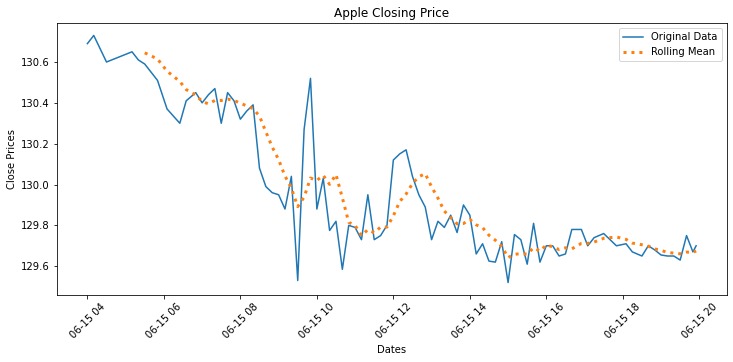

In [12]:
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Apple Closing Price')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')
ax1.plot(ts_orig_roll_mean, color='tab:orange', ls='dotted', linewidth=3, label='Rolling Mean')
# ax.legend()
plt.legend(loc='best')
plt.tight_layout
plt.show()

## Removing Trends

The logarithmic transform takes the log of each point and changes the data into a logarithmic scale.

In [13]:
ts_log = np.log(ts_origin)
ts_sqrt = np.sqrt(ts_origin)
ts_log_roll_mean = ts_log.rolling(roll).mean()
ts_sqrt_roll_mean = ts_sqrt.rolling(roll).mean()

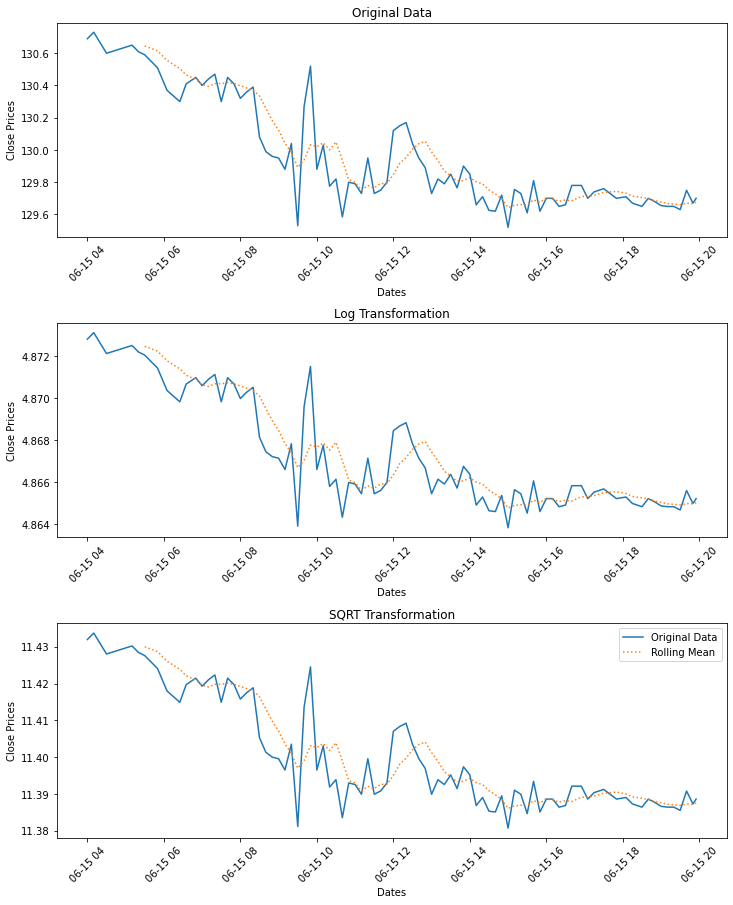

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=False, figsize=(12,15))
ax1.grid(False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Original Data')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')
ax1.plot(ts_orig_roll_mean, color='tab:orange', ls='dotted', label='Rolling Mean')

ax2.grid(False)
ax2.set_xlabel('Dates')
ax2.set_ylabel('Close Prices')
ax2.set_title('Log Transformation')
ax2.tick_params(axis='x', labelrotation=45)
ax2.plot(ts_log, label='Original Data')
ax2.plot(ts_log_roll_mean, color='tab:orange', ls='dotted', label='Rolling Mean')

ax3.grid(False)
ax3.set_xlabel('Dates')
ax3.set_ylabel('Close Prices')
ax3.set_title('SQRT Transformation')
ax3.tick_params(axis='x', labelrotation=45)
ax3.plot(ts_sqrt, label='Original Data')
ax3.plot(ts_sqrt_roll_mean, color='tab:orange', ls='dotted', label='Rolling Mean')

plt.subplots_adjust(hspace = .4)
plt.legend(loc='best')
plt.tight_layout
plt.show()

## Differencing the rolling mean

Differencing would helps stabilize the mean of the time series by removing changes in the level of a time series, which eliminates trend and seasonality. The first-order difference transform consists of taking the data point at the current time and subtracting it with the point before.

In [15]:
ts_origin_min_roll_mean = (ts_origin - ts_origin.rolling(roll).mean())

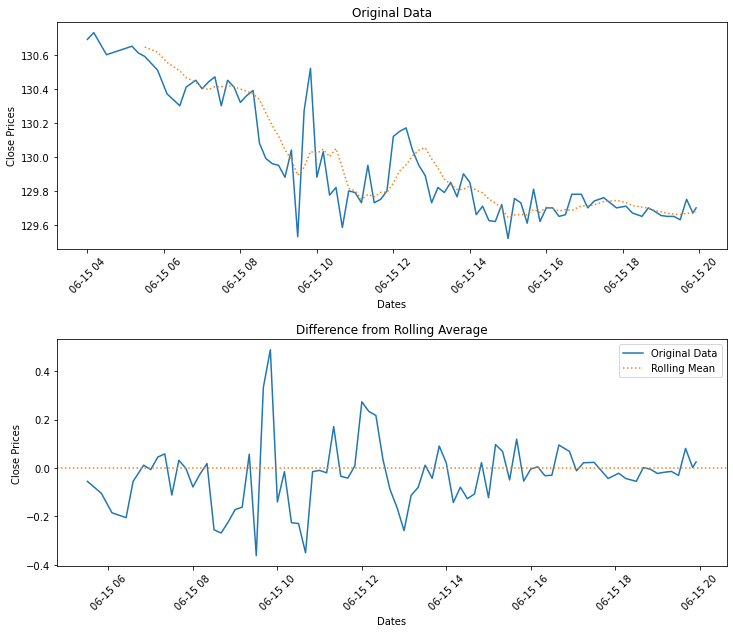

In [16]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=False, figsize=(12,10))
ax1.grid(False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Original Data')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')
ax1.plot(ts_orig_roll_mean, color='tab:orange', ls='dotted', label='Rolling Mean')

ax2.grid(False)
ax2.set_xlabel('Dates')
ax2.set_ylabel('Close Prices')
ax2.set_title('Difference from Rolling Average')
ax2.tick_params(axis='x', labelrotation=45)
ax2.plot(ts_origin_min_roll_mean, label='Original Data')
ax2.axhline(ls='dotted', color='tab:orange',  label='Rolling Mean')

plt.subplots_adjust(hspace = .4)
plt.legend(loc='best')
plt.tight_layout
plt.show()

## Differencing with the weighted rolling mean

In [17]:
ts_ewm = ts_origin.ewm(halflife=6).mean()

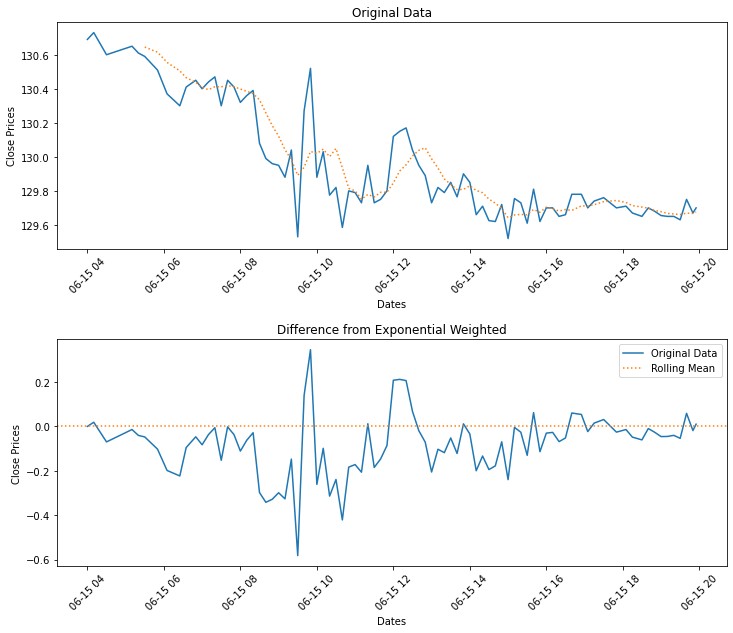

In [18]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=False, figsize=(12,10))

ax1.grid(False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Original Data')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')
ax1.plot(ts_orig_roll_mean, color='tab:orange', ls='dotted', label='Rolling Mean')

ax2.grid(False)
ax2.set_xlabel('Dates')
ax2.set_ylabel('Close Prices')
ax2.set_title('Difference from Exponential Weighted')
ax2.tick_params(axis='x', labelrotation=45)
ax2.plot(ts_origin - ts_ewm, label='Original Data')
ax2.axhline(ls='dotted', color='tab:orange',  label='Rolling Mean')

plt.subplots_adjust(hspace = .4)
plt.legend(loc='best')
plt.tight_layout
plt.show()

## Differencing

Using differencing method to transform the time series by taking the difference of 6 lags between consecutive observations 
to remove the series dependence on time "temporal dependence" 

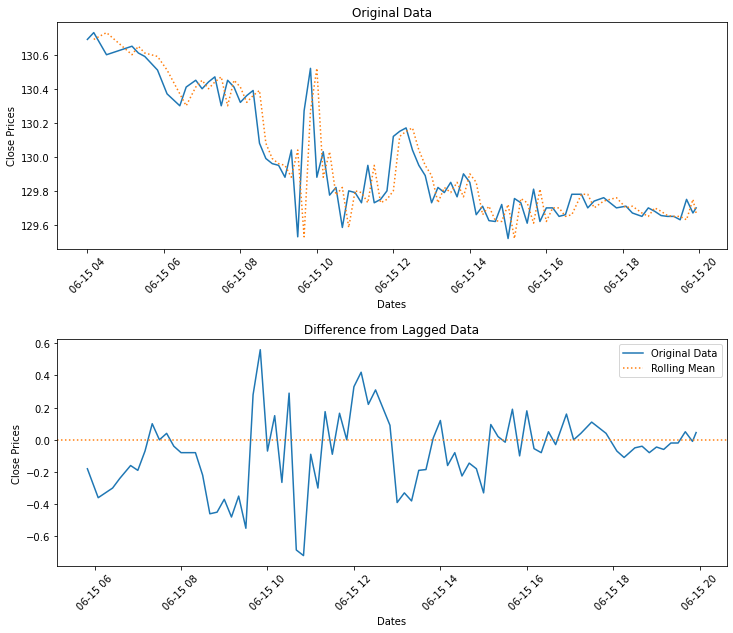

In [19]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=False, figsize=(12,10))

ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Original Data')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')
ax1.plot(ts_origin.shift(1), color='tab:orange', ls='dotted', label='Original Data')

ax2.set_xlabel('Dates')
ax2.set_ylabel('Close Prices')
ax2.set_title('Difference from Lagged Data')
ax2.tick_params(axis='x', labelrotation=45)
ax2.plot(ts_origin.diff(roll), label='Original Data')
ax2.axhline(ls='dotted', color='tab:orange',  label='Rolling Mean')

plt.subplots_adjust(hspace = .4)
plt.legend(loc='best')
plt.tight_layout
plt.show()

In [20]:
decomposition = seasonal_decompose(ts_log, period=3)

In [21]:
ts_trend = decomposition.trend
ts_seasonal = decomposition.seasonal

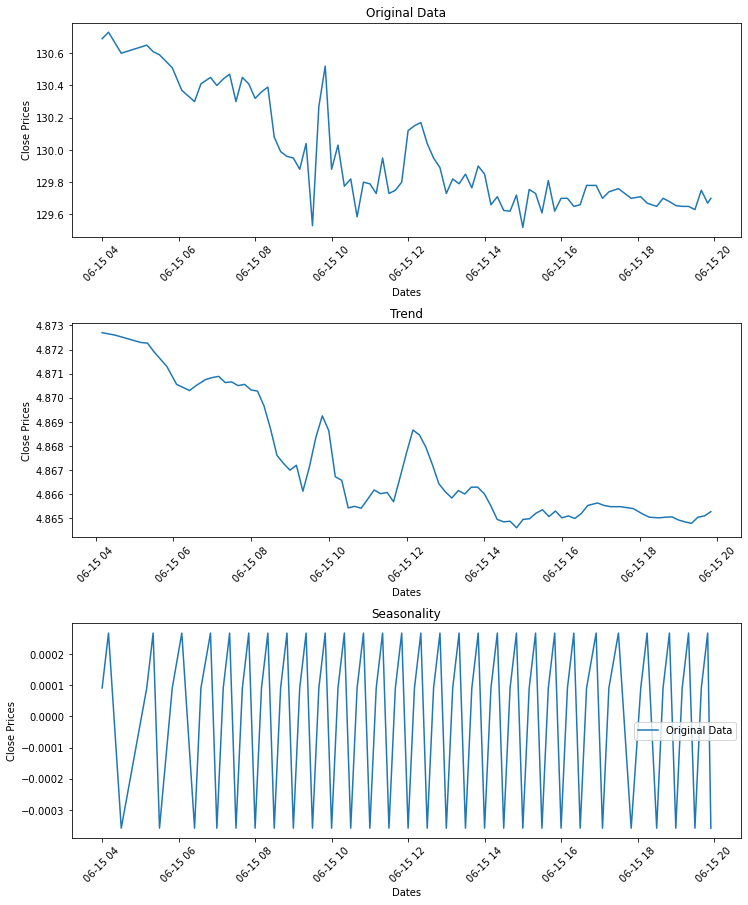

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=False, figsize=(12,15))
ax1.grid(False)
ax1.set_xlabel('Dates')
ax1.set_ylabel('Close Prices')
ax1.set_title('Original Data')
ax1.tick_params(axis='x', labelrotation=45)
ax1.plot(ts_origin, label='Original Data')

ax2.grid(False)
ax2.set_xlabel('Dates')
ax2.set_ylabel('Close Prices')
ax2.set_title('Trend')
ax2.tick_params(axis='x', labelrotation=45)
ax2.plot(ts_trend, label='Original Data')

ax3.grid(False)
ax3.set_xlabel('Dates')
ax3.set_ylabel('Close Prices')
ax3.set_title('Seasonality')
ax3.tick_params(axis='x', labelrotation=45)
ax3.plot(ts_seasonal, label='Original Data')

plt.subplots_adjust(hspace = .4)
plt.legend(loc='best')
plt.tight_layout
plt.show()

In [23]:
ts.adf_test(ts_seasonal)

Test Statistic                -8.205088e+15
p-value                        0.000000e+00
#Lags Used                     1.100000e+01
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64

In [24]:
ts_diff = ts_origin.diff(roll).dropna()
ts.adf_test(ts_diff)

Test Statistic                 -1.658787
p-value                         0.452462
#Lags Used                     12.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64

In [25]:
ts = TS()

In [26]:
date_range = (aapl_5m_df.index <= pd.to_datetime("2021-06-15 12:00:00"))
train = aapl_5m_df.loc[date_range,'close'].to_period("5T")
# exog = aapl_5m_df.loc[date_range, 'close'].to_period("5T")
test_range = (
            (aapl_5m_df.index >= pd.to_datetime("2021-06-15 00:00:00"))
            &
            (aapl_5m_df.index <= pd.to_datetime("2021-06-15 23:59:00"))
            )
# test = aapl_5m_df.loc[test_range, 'open'].to_period("5T")
test = aapl_5m_df.loc[date_range,'open'].to_period("5T")

In [27]:
arima_model = auto_arima(train,m=6,start_p=1,d=1, max_d=6, start_P=1, max_p=6,
                         start_q=1,max_q=6, trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[6] intercept   : AIC=-615.001, Time=3.11 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=-613.303, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=-616.638, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=-617.339, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=-615.144, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=-615.837, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=-615.399, Time=1.58 sec
 ARIMA(0,1,1)(0,0,2)[6] intercept   : AIC=-615.461, Time=0.93 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=-617.228, Time=0.34 sec
 ARIMA(0,1,1)(1,0,2)[6] intercept   : AIC=-616.038, Time=2.76 sec
 ARIMA(0,1,0)(0,0,1)[6] intercept   : AIC=-615.311, Time=0.28 sec
 ARIMA(1,1,1)(0,0,1)[6] intercept   : AIC=-616.957, Time=1.65 sec
 ARIMA(0,1,2)(0,0,1)[6] intercept   : AIC=-618.823, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[6] intercept   : AIC=-618.086, Time=0.16 sec
 ARIMA(0,1,2)(1,0,1)[6] intercept

In [28]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  813
Model:             SARIMAX(1, 1, 3)x(0, 0, [1], 6)   Log Likelihood                 319.164
Date:                             Mon, 14 Jun 2021   AIC                           -626.328
Time:                                     01:44:18   BIC                           -598.131
Sample:                                          0   HQIC                          -615.503
                                             - 813                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9151      0.061     14.933      0.000       0.795       1.035
ma.L1         -1.0004      0.068    -14.607      0.000      -1.135      -0.866
ma.L2          0.0008      0.042      0.018      0.986      -0.082       0.084
ma.L3          0.1140      0.031      3.641      0.000       0.053       0.175
ma.S.L6       -0.1075      0.034     -3.123      0.002      -0.175      -0.040
sigma2         0.0267      0.001     43.238      0.000       0.025       0.028
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1832.20
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
sarimax_model = ts.sarimax_model(train, None, (1,1,3), (0,0,1,6))

In [28]:
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               close   No. Observations:                 1767
Model:             SARIMAX(1, 1, 3)x(0, 0, [1], 6)   Log Likelihood                 737.121
Date:                             Wed, 16 Jun 2021   AIC                          -1462.242
Time:                                     15:56:45   BIC                          -1429.417
Sample:                                 05-17-2021   HQIC                         -1450.110
                                      - 06-15-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8371      0.101      8.271      0.000       0.639       1.035
ma.L1         -0.9134      0.103     -8.880      0.000      -1.115      -0.712
ma.L2         -0.0312      0.025     -1.226      0.220      -0.081       0.019
ma.L3          0.1137      0.019      6.002      0.000       0.077       0.151
ma.S.L6       -0.0839      0.021     -3.947      0.000      -0.126      -0.042
sigma2         0.0253      0.000     69.280      0.000       0.025       0.026
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6349.48
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.42
Prob(H) (two-sided):                  0.17   Kurtosis:                        12.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/boula/miniforge3/envs/python394/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


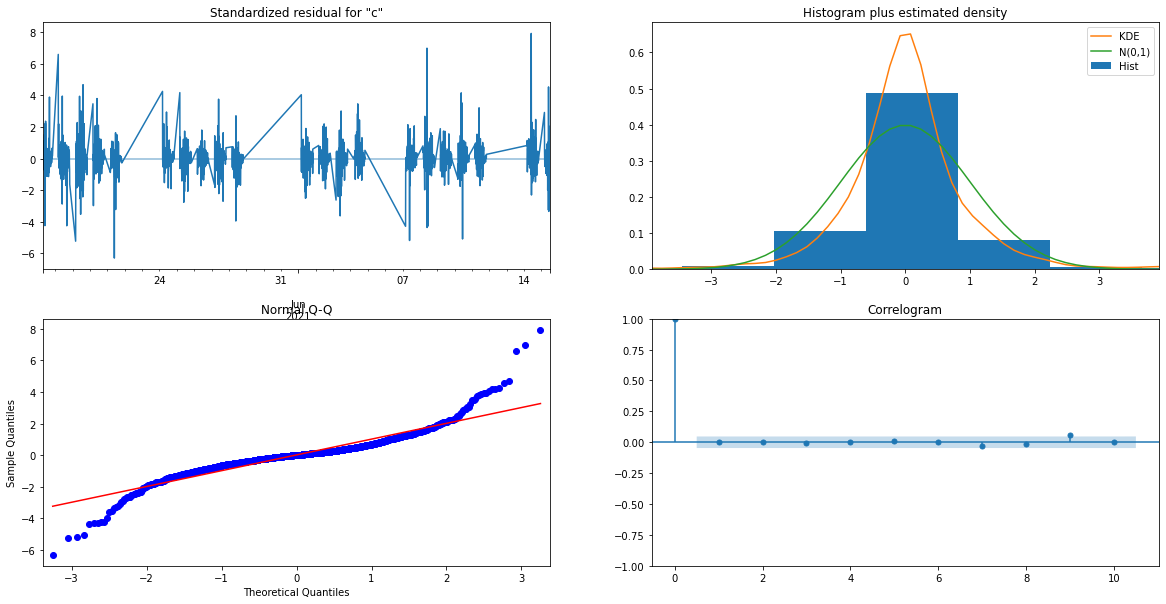

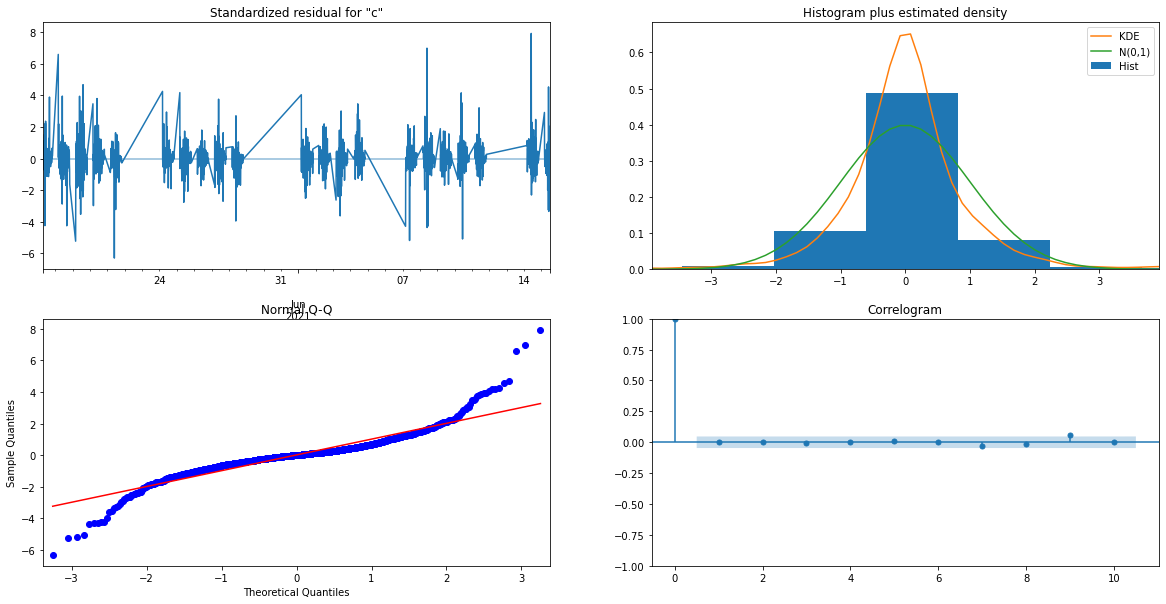

In [29]:
sarimax_model.plot_diagnostics(figsize=(20,10))

In [30]:
train.index = train.index.to_timestamp()
test.index = test.index.to_timestamp()

## Time Series Prediction

In [31]:
pred = sarimax_model.get_prediction(
    start=pd.to_datetime("2021-06-15 12:00:00"),
    end=pd.to_datetime("2021-06-15 13:00:00"),
    dynamic=False)

In [32]:
prediction = pred.predicted_mean
prediction.index = prediction.index.to_timestamp()
Conf_interval = pred.conf_int()

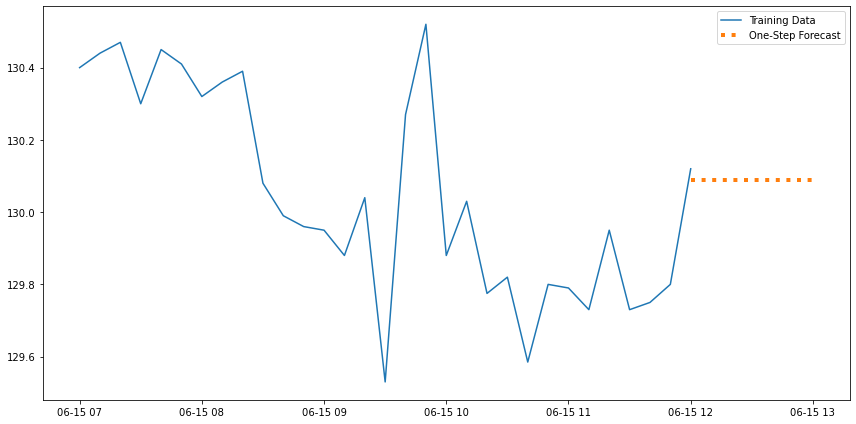

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.loc["2021-06-15 07:00:00":,], label='Training Data')
ax.plot(prediction.loc["2021-06-15 12:00:00":,], label='One-Step Forecast', linewidth=4, ls=':')
ax.legend()
fig.tight_layout()